In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost with one-hot NAICS Clusters (DGI Base)
XGBoost model, one hot encoded values from k means clustering

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot 

## Import Processed Datasets

##### Get loans data, append clusters

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [7]:
sba_loans.filter(like='NAICS').columns

Index(['NAICS', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc', 'NAICS_num',
       'menc_NAICS', 'cenc_NAICS', 'menc_grp_NAICS'],
      dtype='object')

In [8]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('66_DATA_embeddings_tsne_naics.parquet'))

In [9]:
clus_cols = [c for c in embed_df if c.startswith('NC__')]
len(clus_cols)

9

In [10]:
sba_loans = sba_loans.drop(columns = clus_cols, errors='ignore') \
    .merge(embed_df[clus_cols + ['NAICS_orig']].rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS', how='left')

In [11]:
sba_loans[clus_cols].describe()

,NC__0,NC__1,NC__2,NC__3,NC__4,NC__5,NC__6,NC__7,NC__8
count,688081.00000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000
mean,0.08766,0.131871,0.111285,0.182824,0.100536,0.057178,0.250016,0.011393,0.067238
std,0.28280,0.338351,0.314485,0.386523,0.300714,0.232182,0.433022,0.106126,0.250433
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [13]:
train_df.shape

(425594, 59)

#### Set the predictor features.  Include one-hot NAICS

In [14]:
predictor_features = setup.predictor_features + clus_cols
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'NC__0', 'NC__1', 'NC__2', 'NC__3', 'NC__4', 'NC__5', 'NC__6', 'NC__7', 'NC__8']


In [15]:
train_df[predictor_features + ['target']].corr()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,NC__0,NC__1,NC__2,NC__3,NC__4,NC__5,NC__6,NC__7,NC__8,target
NoEmp,1.000000,0.052510,-0.009243,0.093125,-0.038672,0.002058,0.006517,0.023469,-0.001929,-0.009150,0.023155,0.000260,0.006934,-0.033227,0.010418,-0.002176,-0.027838
CreateJob,0.052510,1.000000,-0.046967,0.101755,0.028831,0.009019,0.036918,0.046083,-0.014991,-0.005393,-0.009500,-0.003376,0.029813,-0.021167,0.005096,-0.000937,-0.009540
LowDoc,-0.009243,-0.046967,1.000000,-0.133731,0.154037,-0.119292,0.039258,-0.025117,0.049489,-0.035680,0.055988,0.028535,-0.014907,-0.029313,-0.010318,-0.043137,-0.076836
DisbursementGross,0.093125,0.101755,-0.133731,1.000000,-0.067410,-0.006023,0.082087,0.167835,0.000961,-0.048201,0.090056,-0.013118,0.015601,-0.172300,0.050113,0.005869,-0.122857
new_business,-0.038672,0.028831,0.154037,-0.067410,1.000000,-0.046626,0.136142,0.023139,-0.002475,-0.019728,-0.047895,-0.003002,0.057546,0.030167,-0.021886,-0.018322,0.014277
urban_flag,0.002058,0.009019,-0.119292,-0.006023,-0.046626,1.000000,-0.004093,-0.047373,0.012445,0.006034,-0.030009,0.015248,-0.003669,0.030740,-0.002985,0.004420,0.054391
franchise_flag,0.006517,0.036918,0.039258,0.082087,0.136142,-0.004093,1.000000,0.083507,-0.025324,-0.024066,-0.050921,-0.030901,0.202095,-0.032308,-0.015306,-0.042240,-0.011047
NC__0,0.023469,0.046083,-0.025117,0.167835,0.023139,-0.047373,0.083507,1.000000,-0.120268,-0.108310,-0.149443,-0.105386,-0.078544,-0.186407,-0.034656,-0.087268,-0.014612
NC__1,-0.001929,-0.014991,0.049489,0.000961,-0.002475,0.012445,-0.025324,-0.120268,1.000000,-0.129615,-0.178839,-0.126116,-0.093994,-0.223074,-0.041473,-0.104434,-0.048854
NC__2,-0.009150,-0.005393,-0.035680,-0.048201,-0.019728,0.006034,-0.024066,-0.108310,-0.129615,1.000000,-0.161058,-0.113576,-0.084648,-0.200894,-0.037349,-0.094050,0.039634


In [16]:
with open(Path(setup.temp_path).joinpath('67_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [17]:
best_params_df = pd.read_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [18]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [19]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = setup.xgb_n_estimators)

In [20]:
xgb_model = xgb_model.set_params(**xgb_params)

In [21]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.49985	validation_1-logloss:0.50267
[1]	validation_0-logloss:0.49357	validation_1-logloss:0.49635
[2]	validation_0-logloss:0.48831	validation_1-logloss:0.49104
[3]	validation_0-logloss:0.48385	validation_1-logloss:0.48654
[4]	validation_0-logloss:0.47997	validation_1-logloss:0.48262
[5]	validation_0-logloss:0.47668	validation_1-logloss:0.47931
[6]	validation_0-logloss:0.47387	validation_1-logloss:0.47648
[7]	validation_0-logloss:0.47127	validation_1-logloss:0.47394
[8]	validation_0-logloss:0.46912	validation_1-logloss:0.47182
[9]	validation_0-logloss:0.46729	validation_1-logloss:0.47002
[10]	validation_0-logloss:0.46574	validation_1-logloss:0.46848
[11]	validation_0-logloss:0.46429	validation_1-logloss:0.46707
[12]	validation_0-logloss:0.46315	validation_1-logloss:0.46594
[13]	validation_0-logloss:0.46214	validation_1-logloss:0.46496
[14]	validation_0-logloss:0.46130	validation_1-logloss:0.46412
[15]	validation_0-logloss:0.46054	validation_1-logloss:0.46336
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

##### Save the model

In [22]:
xgb_model.save_model(Path(setup.temp_path).joinpath('67_MODEL_xgboost.json'))

In [23]:
with open(Path(setup.temp_path).joinpath('67_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [24]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [25]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.186872,0.107894,0.016585,0.648356,0.181791
1,0.270396,0.094401,0.016585,0.648356,0.284890


## Decision Threshold
Max f1, on training data

In [26]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [27]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [28]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('67_REPORT_thresh_tune.csv'), index=False)

In [29]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.22


,thresh,f1
11,0.22,0.438030
12,0.24,0.437312


##### Apply decision threshold
All datasets

In [30]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [31]:
pred_df['predict_bin'].value_counts()

predict_bin
0    360081
1    328000
Name: count, dtype: int64

In [32]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('67_DATA_combined_predictions.parquet'))

## Metrics

In [33]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('67_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.620377,0.434766,0.309905,0.728133,0.358442,0.716996,NaN
1,train,0.617184,0.438030,0.312037,0.734678,0.361098,0.716837,NaN
2,val,0.618346,0.441508,0.315690,0.734075,0.361321,0.715481,NaN
0,test,0.616756,0.437073,0.311850,0.730341,0.361347,0.715041,0.0
1,test,0.631584,0.427212,0.303561,0.720831,0.348755,0.722276,1.0


## Lift
Test data

In [34]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

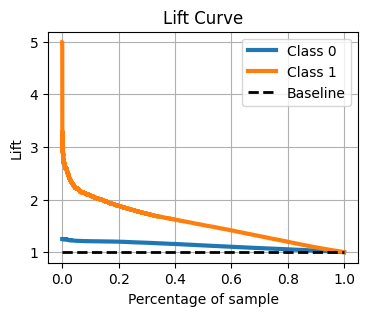

In [35]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('67_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [36]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [37]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('67_REPORT_importance_gain.csv'), index=True)

In [38]:
feat_impgain.head()

,importance
urban_flag,659.698181
LowDoc,111.677612
DisbursementGross,71.017113
NC__6,59.049049
NC__3,32.962017


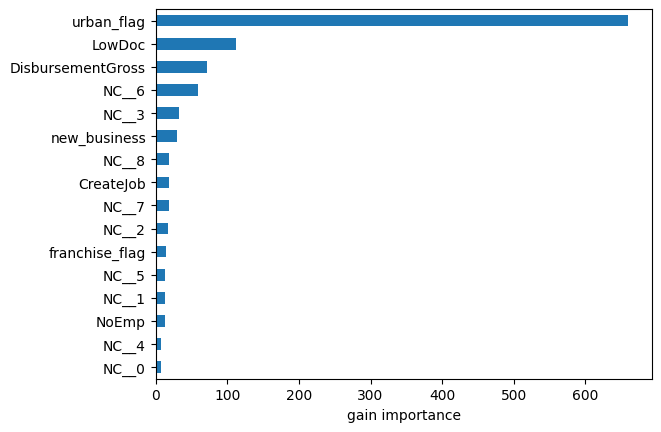

In [39]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('67_PLOT_importance_gain.png'))

##### Permutation Importance

In [40]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [41]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [42]:
perm_importance_df.head(5)

,features,importance,abs_importance
3,DisbursementGross,0.078822,0.078822
5,urban_flag,0.039377,0.039377
1,CreateJob,0.028347,0.028347
2,LowDoc,0.015113,0.015113
13,NC__6,0.013181,0.013181


In [43]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('67_DATA_importance_perturb.csv'),
            index=False)

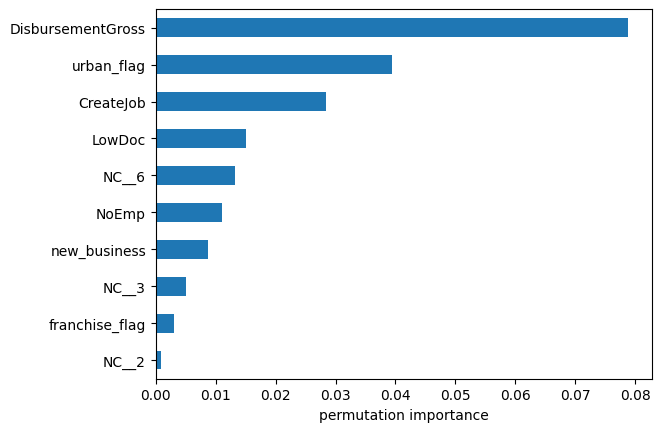

In [44]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('67_PLOT_importance_perturb.png'))

## PDP Plot - One Hot

In [45]:
naics_features = list(train_df.filter(like='NC_').columns)

In [46]:
plt.close()

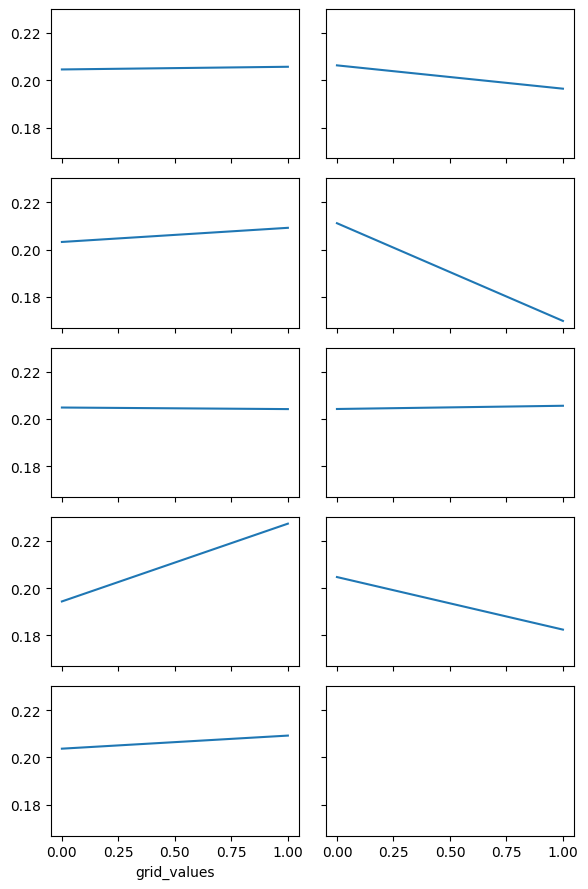

In [47]:
fig, ax = plt.subplots(int(np.ceil(len(naics_features)/2)), 2, sharex=True, sharey=True, figsize=(6, 9))
for i in range(len(naics_features)):
    col = int(i % 2)
    row = int(np.floor(i / 2))
    results = partial_dependence(xgb_model, train_df[predictor_features], 
                                 [naics_features[i]])
    pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})
    pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax[row, col])

fig.tight_layout()
fig.savefig(Path(setup.temp_path).joinpath('67_PLOT_pdp_naics_onehot.png'),
               bbox_inches='tight')
plt.show()